In [1]:
import pandas as pd
import requests
import geopandas as gpd
import folium
from folium.plugins import HeatMap
import osmnx as ox
import matplotlib.pyplot as plt
import seaborn as sns

from shapely.geometry import Point
import numpy as np
from collections import Counter
import utils


In [2]:
# Setting default parameters for all charts
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlecolor'] = 'darkblue'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.labelcolor'] = 'gray'

# Other optional settings for consistent styling
plt.rcParams['xtick.labelsize'] = 12  # Font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 12  # Font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 12  # Font size for legend
plt.rcParams['figure.figsize'] = (10, 6)  # Default figure size

# To apply grid and color consistency
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['axes.grid'] = True

plt.style.use('ggplot')
pd.set_option('display.max_columns',None)

In [5]:

def getRoadFeatures(lat:float, lon:float) -> tuple:

    """
    Retrieves road features from OpenStreetMap (OSM) data using the Overpass API based on specified latitude and longitude.

    Parameters:
    ----------
    lat : float
        The latitude of the traffic counter installed on the road to query.
    lon : float
        The longitude of the traffic counter installed on the road to query.

    Returns:
    -------
    tuple
        A tuple containing the following road features (values may be `None` if not found):
        - lanes : int or None
            Total number of lanes on the road, if available.
        - forward_lanes : int or None
            Number of lanes in the forward direction, if available.
        - backward_lanes : int or None
            Number of lanes in the backward direction, if available.
        - width : str or None
            The width of the road, if specified.
        - maxspeed : str or None
            The maximum speed limit on the road, if specified.
        - oneway : str or None
            Indicates if the road is one-way (`"yes"` or `"no"`), if available.
        - carriageway_type : str or None
            Type of carriageway (e.g., `"residential"`, `"highway"`, etc.), if specified.

    Notes:
    ------
    - The function uses a 5-meter radius around the provided coordinates to search for nearby roads.
    - Extracted attributes are returned as-is from OSM data and may vary based on local tagging.
    
    """

    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = f"""
    [out:json];
    way(around:5,{lat},{lon})["highway"];
    out body;
    """
    response = requests.get(overpass_url, params={'data': overpass_query})
    data = response.json()

    lanes = None
    forward_lanes=None
    backward_lanes=None
    width = None
    maxspeed = None  # Initialize maxspeed variable
    oneway = None    # Initialize oneway variable
    carriageway_type = None  # Initialize carriageway type variable

    # Extract lanes, width, and maxspeed information from the response
    if data['elements']:
        for element in data['elements']:
            if 'tags' in element:
                tags = element['tags']
                
                
                # Extract lanes information
                if 'lanes' in tags:
                    lanes = tags['lanes']
                if 'lanes:forward' in tags:
                    # Calculate total lanes if forward/backward data is present
                    forward_lanes = int(tags.get('lanes:forward', 0))
                if 'lanes:backward' in tags:
                    backward_lanes = int(tags.get('lanes:backward', 0))
                
                # Extract width information
                if 'width' in tags:
                    width = tags['width']
                
                # Extract maxspeed information
                if 'maxspeed' in tags:
                    maxspeed = tags['maxspeed']
                # Extract oneway information
                if 'oneway' in tags:
                    oneway = tags['oneway']
                
                # Extract carriageway type
                if 'highway' in tags:
                    carriageway_type = tags['highway']

    return lanes,forward_lanes,backward_lanes, width, maxspeed, oneway, carriageway_type


# Apply the function to the dataset
def extractRoadnformation(df:pd.DataFrame)-> pd.DataFrame:

    """
    Extracts detailed road features from OpenStreetMap (OSM) for each traffic counter in the provided DataFrame.

    This function uses the `getRoadFeatures` helper function to retrieve road attributes (e.g., lanes, width, speed limit) 
    from OSM based on the latitude and longitude coordinates for each record in the input DataFrame. 
    It appends these attributes as new columns to the DataFrame.

    Parameters:
    ----------
    df : pd.DataFrame
        A DataFrame containing traffic counter data, with each row representing a unique counter.
        Required columns:
        - `latitude`: Latitude of the counter's location.
        - `longitude`: Longitude of the counter's location.

    Returns:
    -------
    pd.DataFrame
        The original DataFrame with additional columns for road features:
        - `lanes`: Total number of lanes on the road, if available.
        - `fwd_lanes`: Number of lanes in the forward direction, if available.
        - `bkwd_lanes`: Number of lanes in the backward direction, if available.
        - `width`: The width of the road, if specified.
        - `max_speed`: The maximum speed limit on the road, if specified.
        - `oneway`: Indicates if the road is one-way (`"yes"` or `"no"`), if available.
        - `carriageway_type`: Type of carriageway (e.g., `"residential"`, `"highway"`, etc.), if specified.

    Notes:
    ------
    - This function iterates over each row in the DataFrame and queries OSM data for each counter's location.
    - The function may be slowed down by API limits if used with many locations. Consider using a delay.
    - Retrieved OSM data may vary by location, so some attributes may be missing (filled as `None`).
    """


    lanes_info = []
    f_lanes_info = []
    b_lanes_info = []
    width_info = []
    mspeed_info = []
    oneway_info = []
    carriageway_info = []
    
    for idx, row in df.iterrows():
        lat = row['latitude']
        lon = row['longitude']
        lanes,flanes,blanes, width,mspeed, oneway, carriageway_type = getRoadFeatures(lat, lon)
        lanes_info.append(lanes)
        f_lanes_info.append(flanes)
        b_lanes_info.append(blanes) 
        width_info.append(width)
        mspeed_info.append(mspeed)
        oneway_info.append(oneway)
        carriageway_info.append(carriageway_type)
        #time.sleep(1)  # Be polite with API usage
    
    df['lanes'] = lanes_info
    df['fwd_lanes'] = f_lanes_info
    df['bkwd_lanes'] = b_lanes_info
    df['width'] = width_info
    df['max_speed']=mspeed_info
    df['oneway'] = oneway_info
    df['carriageway_type'] = carriageway_info
    return df

## 1. Data Engineering (Traffic Counter Point Data)

In [482]:
fname='count_points.csv'
df_count=pd.read_csv(f'data/{fname}') # Reading traffic counter metadata
df_count.head()

,count_point_id,region_id,region_name,local_authority_id,local_authority_name,road_name,road_type,start_junction_road_name,end_junction_road_name,easting,northing,latitude,longitude,link_length_km,link_length_miles,lanes,width,fwd_lanes,bkwd_lanes,max_speed,std_lane_width_meters,oneway,carriageway_type
0,998097,6,London,108,Wandsworth,C,Minor,NaN,NaN,525020,173960,51.450833,-0.202202,NaN,NaN,NaN,NaN,NaN,NaN,0,3.0,NaN,NaN
1,998071,6,London,108,Wandsworth,U,Minor,NaN,NaN,523303,174410,51.455254,-0.226743,NaN,NaN,2.0,NaN,NaN,NaN,32,3.0,NaN,residential
2,998065,6,London,108,Wandsworth,B237,Minor,NaN,NaN,528100,173968,51.450217,-0.157899,NaN,NaN,NaN,NaN,NaN,NaN,32,3.0,NaN,secondary
3,990355,6,London,108,Wandsworth,C,Minor,NaN,NaN,526080,174220,51.452935,-0.186863,NaN,NaN,NaN,NaN,NaN,NaN,0,3.0,NaN,NaN
4,953192,6,London,108,Wandsworth,U,Minor,NaN,NaN,528346,175841,51.466994,-0.153682,NaN,NaN,1.0,NaN,NaN,NaN,32,3.0,NaN,residential


In [484]:
df_count.isna().any() # Checking for NA values (particularly for GPS Coordinates)

count_point_id              False
region_id                   False
region_name                 False
local_authority_id          False
local_authority_name        False
road_name                   False
road_type                   False
start_junction_road_name     True
end_junction_road_name       True
easting                     False
northing                    False
latitude                    False
longitude                   False
link_length_km               True
link_length_miles            True
lanes                        True
width                        True
fwd_lanes                    True
bkwd_lanes                   True
max_speed                   False
std_lane_width_meters       False
oneway                       True
carriageway_type             True
dtype: bool

In [447]:

df_count = extractRoadnformation(df_count) # Extracting road features (e.g., number of lanes, max speed, forward lanes, backward lanes, road width). These features have been extracted but are not currently used due to insufficient data. They are kept here to be utilized if additional data becomes available in the future.
df_count['max_speed'].fillna('0 mph',inplace=True) # Filling na values for max_speed with '0 mph' to process this feature
df_count['max_speed']=df_count['max_speed'].apply(lambda x: round(int(x.replace(' mph',''))*1.60934)) # Covnverting mph to kmh
replace_with_none = ['footway', 'pedestrian', 'tertiary', 'cycleway', 'path', 'service'] # OSM overpass API gets the road features based on the provided GPS points. Inaccurate GPS points may lead to fetching wrong details. Excluding any uneccearry details
df_count['carriageway_type']=df_count['carriageway_type'].apply(lambda x: None if x in replace_with_none else x)
df_count['std_lane_width_meters']=df_count.apply(lambda x: 3.5 if x['road_type']=='Major' else 3,axis=1) # Adding a feature standard lane width following the design manual for roads and bridges
df_count.head()

In [451]:
fname='count_points.csv'
df_count.to_csv(f'data/{fname}',index=False) # Saving Data

# 2. Data Engineering (Raw Count Data)

In [6]:
def getTotalCars(row:pd.DataFrame)->float:
     
    """
    Calculates the total number of Passenger Car Equivalents (PCE) for various types of vehicles on the road.

    This function uses Passenger Car Equivalent (PCE) values to convert diverse vehicle types 
    (e.g., bicycles, motorbikes, buses, and trucks) into an equivalent measure based on the 
    impact of a single passenger car. This allows for standardized comparison of mixed-traffic flow.

    Parameters:
    ----------
    row : pd.DataFrame
        A DataFrame row containing vehicle count data with specific columns for each vehicle type 
        (e.g., `pedal_cycles`, `two_wheeled_motor_vehicles`, `cars_and_taxis`, etc.).

    Returns:
    -------
    float
        The total Passenger Car Equivalent (PCE) count for the input vehicles, providing a measure 
        of traffic flow impact in terms of passenger car units.

    Notes:
    ------
    PCE factors used for different vehicles:
    - pedal_cycles: 0.2
    - two_wheeled_motor_vehicles: 0.6
    - cars_and_taxis: 1.0
    - buses_and_coaches: 2.5
    - lgvs (Light Goods Vehicles): 1.2
    - hgvs with various axles: ranging from 1.8 to 4.2

    The specific values may vary based on region or local guidelines in traffic engineering.
    """

    total_cars=(row['pedal_cycles'] * utils.PEDAL_CYCLES
                +row['two_wheeled_motor_vehicles'] * utils.TWO_WHEELED_MOTOR_VEHICLES
                +row['cars_and_taxis'] * utils.CARS_AND_TAXIS
                +row['buses_and_coaches'] * utils.BUSES_AND_COACHES
                +row['lgvs'] * utils.LGVS
                +row['hgvs_2_rigid_axle'] * utils.HGVS_2_RIGID_AXLE
                +row['hgvs_3_rigid_axle'] * utils.HGVS_3_RIGID_AXLE
                +row['hgvs_4_or_more_rigid_axle'] * utils.HGVS_4_OR_MORE_RIGID_AXLE
                +row['hgvs_3_or_4_articulated_axle'] * utils.HGVS_3_OR_4_ARTICULATED_AXLE
                +row['hgvs_5_articulated_axle'] * utils.HGVS_5_ARTICULATED_AXLE
                +row['hgvs_6_articulated_axle'] * utils.HGVS_6_ARTICULATED_AXLE)
    return total_cars

def getRoadCapacity(row):
    road_capacity_info = {
    "A": {
        "description": "Primary Roads (Arterial)",
        "typical_lanes": "2 lanes",
        "capacity_per_lane": "1,500–2,000 vehicles/hour",
        "avg_capacity_per_lane":utils.AVG_ROAD_CAPACITY_A
    },
    "B": {
        "description": "Secondary Roads (Collector roads)",
        "typical_lanes": "1 lane",
        "capacity_per_lane": "800–1,500 vehicles/hour",
        "avg_capacity_per_lane":utils.AVG_ROAD_CAPACITY_B
    },
    "U": {
        "description": "Unclassified Roads (Minor local roads)",
        "typical_lanes": "1 lane",
        "capacity_per_lane": "200–800 vehicles/hour",
        "avg_capacity_per_lane":utils.AVG_ROAD_CAPACITY_U
    },
    "C": {
        "description": "Local/Residential Roads",
        "typical_lanes": "1 lane",
        "capacity_per_lane": "200–800 vehicles/hour",
        "avg_capacity_per_lane":utils.AVG_ROAD_CAPACITY_C
    }
}
    

    return road_capacity_info[row['road_classification']]['avg_capacity_per_lane']


In [7]:
df=pd.read_csv('data/raw_count.csv',parse_dates=['count_date']) # Reading Raw Count Data
count_df=pd.read_csv('data/count_points.csv') # Reading processed count point data
count_df.head()

,count_point_id,region_id,region_name,local_authority_id,local_authority_name,road_name,road_type,start_junction_road_name,end_junction_road_name,easting,northing,latitude,longitude,link_length_km,link_length_miles,lanes,width,fwd_lanes,bkwd_lanes,max_speed,std_lane_width_meters,oneway,carriageway_type
0,998097,6,London,108,Wandsworth,C,Minor,NaN,NaN,525020,173960,51.450833,-0.202202,NaN,NaN,NaN,NaN,NaN,NaN,0,3.0,NaN,NaN
1,998071,6,London,108,Wandsworth,U,Minor,NaN,NaN,523303,174410,51.455254,-0.226743,NaN,NaN,2.0,NaN,NaN,NaN,32,3.0,NaN,residential
2,998065,6,London,108,Wandsworth,B237,Minor,NaN,NaN,528100,173968,51.450217,-0.157899,NaN,NaN,NaN,NaN,NaN,NaN,32,3.0,NaN,secondary
3,990355,6,London,108,Wandsworth,C,Minor,NaN,NaN,526080,174220,51.452935,-0.186863,NaN,NaN,NaN,NaN,NaN,NaN,0,3.0,NaN,NaN
4,953192,6,London,108,Wandsworth,U,Minor,NaN,NaN,528346,175841,51.466994,-0.153682,NaN,NaN,1.0,NaN,NaN,NaN,32,3.0,NaN,residential


In [8]:
df=df.merge(count_df[['count_point_id','lanes','width','fwd_lanes','bkwd_lanes','max_speed','std_lane_width_meters','oneway','carriageway_type']],
         how='left',
         on='count_point_id')

df['lanes']=df['lanes'].astype(float)
df[['region_id','region_name','local_authority_id','local_authority_name']].nunique()

region_id               1
region_name             1
local_authority_id      1
local_authority_name    1
dtype: int64

In [9]:
# Dropping columns 'region_id', 'region_name', 'local_authority_id', 'local_authority_name' as each has a single unique value,
# which will not contribute to the model's predictive power.
df.drop(columns=['region_id','region_name','local_authority_id','local_authority_name'],inplace=True)

# Applying the function 'getTotalCars' across each row to calculate 'total_cars' based on Passenger Car Equivalent (PCE) values,
# a standard measure in traffic engineering to represent vehicle counts in terms of equivalent car units.
df['total_cars']=df.apply(getTotalCars,axis=1) 
df['road_classification']=df['road_name'].apply(lambda x: x[0]) # Getting the road classification (A, B, C, U)
df['avg_road_capacity']=df.apply(getRoadCapacity,axis=1) # Calculating average road capacity depending upon the road classification as per UK Design Manual for Roads and Bridges (DMRB)
df['congestion_ratio']=df['total_cars']/df['avg_road_capacity'] # Calculating road congestion based on the total cars/hour and average road capacity 

## 3. Exploratory Data Analysis


In [10]:

# Creating a summary DataFrame 'tdf' to analyze year data availability for each unique road count point.
# The code groups data by 'count_point_id' and collects all unique years of data availability for each point.

tdf=pd.DataFrame(df.groupby(['count_point_id'])['year'].unique()).reset_index() # Groups by 'count_point_id' and lists unique years for each

# Calculating and adding columns to summarize year information for each count point:
tdf['total_years'] = tdf['year'].apply(len) # Counts the total number of unique years with data for each count point
tdf['min_year'] = tdf['year'].apply(min) # Finds the earliest (oldest) year with data availability
tdf['max_year'] = tdf['year'].apply(max) # Finds the latest (most recent) year with data availability
tdf[tdf['max_year']>2013]

,count_point_id,year,total_years,min_year,max_year
0,6109,"[2002, 2011, 2016, 2021]",4,2002,2021
1,6111,"[2004, 2009, 2010, 2012, 2013, 2017, 2021]",7,2004,2021
2,6757,"[2007, 2011, 2017]",3,2007,2017
3,6774,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",12,2000,2022
4,7571,"[2002, 2012, 2020]",3,2002,2020
...,...,...,...,...,...
97,943000,"[2008, 2010, 2011, 2013, 2014, 2015, 2016, 201...",10,2008,2019
98,943002,"[2008, 2010, 2011, 2012, 2013, 2014, 2015, 201...",11,2008,2019
99,943003,"[2009, 2010, 2011, 2012, 2013, 2014, 2016, 201...",10,2009,2019
102,943006,"[2008, 2011, 2012, 2013, 2014, 2017, 2018, 2019]",8,2008,2019


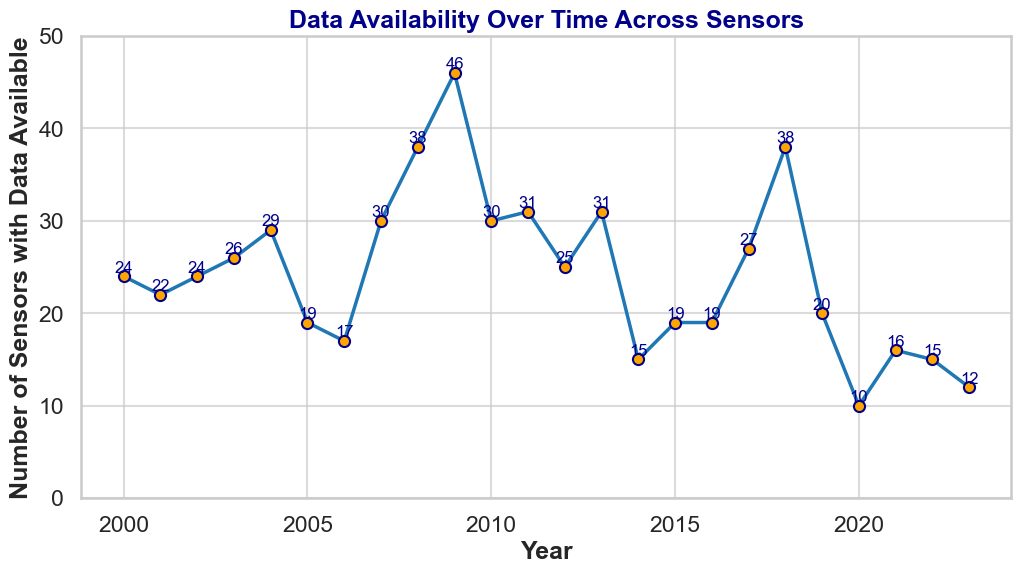

In [12]:
# Flattening the 'year' column to count the occurrence of each year across all sensors
years = [year for sublist in tdf['year'] for year in sublist]
year_counts = Counter(years)

# Creating lists for plotting
years_sorted = sorted(year_counts.keys())
sensor_counts = [year_counts[year] for year in years_sorted]


plt.figure(figsize=(12, 6))
sns.set(style="whitegrid", context="talk")
plt.plot(years_sorted, sensor_counts, marker='o', linestyle='-', color='#1f77b4', linewidth=2.5, markersize=8, markerfacecolor='orange', markeredgewidth=1.5, markeredgecolor='darkblue')

plt.title("Data Availability Over Time Across Sensors")
plt.xlabel("Year")
plt.ylabel("Number of Sensors with Data Available")
for year, count in zip(years_sorted, sensor_counts):
    if count > 1:
        plt.text(year, count + 0.1, f"{count}", ha='center', va='bottom', color='darkblue', fontsize=12)

plt.grid(visible=True)
plt.ylim(0, max(sensor_counts) + 4)

# Showing the plot
plt.show()

### 3.1 Counter Points (Sensors) Data Analysis
The bar chartbelow titled **"Outdated vs Current Sensors"** provides an overview of the status of traffic sensors based on their latest data availability, using 2013 as a cutoff to classify sensors as either "Outdated" or "Current." The 10-year threshold was chosen because, in traffic engineering, a decade often marks a point where data can become less representative of current conditions due to evolving traffic patterns, infrastructure changes, and shifts in vehicle technology. Sensors with data up to or beyond 2013 are labeled as "Current," indicating they still provide relevant insights, while those with only pre-2013 data are considered "Outdated" and may require updating to maintain data accuracy. The chart shows two bars, with the longer, light blue bar representing "Current Sensors," and a shorter, red bar for "Outdated Sensors," allowing a quick assessment of the sensor network’s data currency. This analysis supports decision-making for sensor maintenance and upgrade planning, ensuring data reliability in traffic monitoring systems.

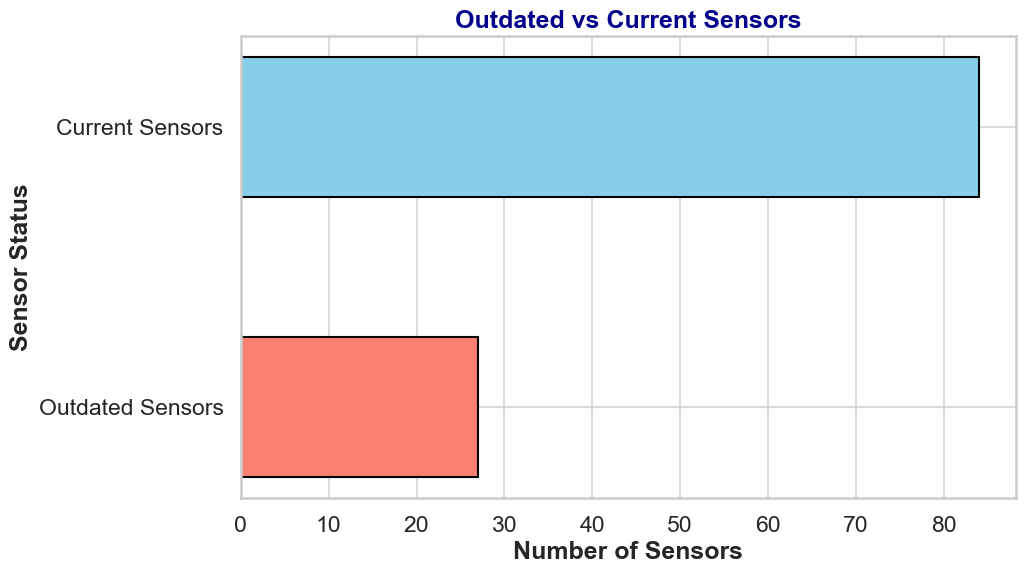

In [13]:
year_threshold=2013

x = [tdf[tdf['max_year'] < year_threshold].shape[0], tdf[tdf['max_year'] >= year_threshold].shape[0]]
y = ['Outdated Sensors', 'Current Sensors']

plt.figure(figsize=(10, 6))
plt.barh(y, x, color=['salmon', 'skyblue'], edgecolor='black', height=0.5)
plt.title('Outdated vs Current Sensors')
plt.xlabel('Number of Sensors')
plt.ylabel('Sensor Status')
plt.show()

### 3.2 Analysis of Outdated Sensor Distribution by Road Type
The bar chart titled **"Number of Major and Minor Roads with Outdated Sensors Data"** displays the count of outdated sensors across major and minor roads. In the chart, the x-axis represents the **Number of Outdated Sensors** while the y-axis differentiates **Road Type** into "Major Roads" and "Minor Roads." The shorter blue bar for major roads and the longer red bar for minor roads indicate that a greater number of outdated sensors are installed on minor roads compared to major roads, providing a quick visual comparison of outdated sensor distribution by road type.

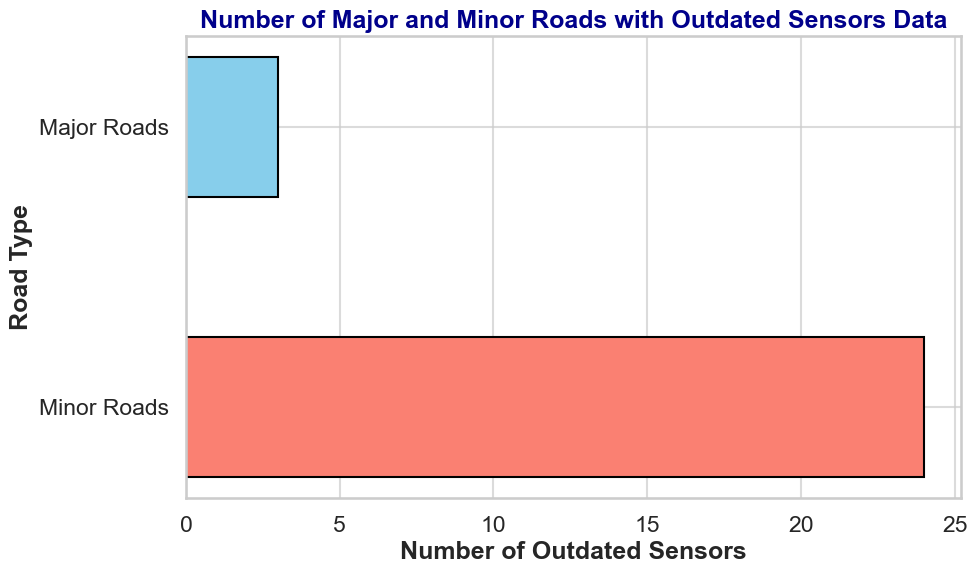

In [14]:
outdated_sensors=tdf[tdf['max_year']<year_threshold]['count_point_id'].values
odt_sens_vc= dict(count_df[count_df['count_point_id'].isin(outdated_sensors)]['road_type'].value_counts())

x = [odt_sens_vc['Minor'], odt_sens_vc['Major']]
y = ['Minor Roads', 'Major Roads']

plt.figure(figsize=(10, 6))
plt.barh(y, x, color=['salmon', 'skyblue'], edgecolor='black', height=0.5)
plt.title('Number of Major and Minor Roads with Outdated Sensors Data')
plt.xlabel('Number of Outdated Sensors')
plt.ylabel('Road Type')
plt.show()



In [503]:
major_rd_df=df[(df['road_type']=='Major')&(~df['count_point_id'].isin(outdated_sensors))].copy()
minor_rd_df=df[(df['road_type']=='Minor')&(~df['count_point_id'].isin(outdated_sensors))].copy()

## Major Roads Morning Peak Hours Congestion Spots

In [504]:
# Major Roads
df_grouped_major=pd.DataFrame(major_rd_df.groupby(['count_point_id','latitude','longitude','direction_of_travel','hour'])['congestion_ratio'].mean())
df_grouped_major.reset_index(inplace=True)
df_grouped_major['hour_category']=df_grouped_major['hour'].transform(lambda x: 'morning_peak' if x<9 else ('evening_peak' if x>15 else 'day_time'))

df_grouped_major=df_grouped_major[['count_point_id','latitude','longitude', 'direction_of_travel', 'hour', 'hour_category','congestion_ratio']]


df_maj_morning=df_grouped_major[df_grouped_major['hour_category']=='morning_peak'].copy()
df_maj_morning['density']=df_maj_morning['congestion_ratio'].apply(lambda x: x*20 if x<=1 else x*20)

# Create a map centered at the average latitude and longitude
m = folium.Map(location=[df_maj_morning['latitude'].mean(), df_maj_morning['longitude'].mean()], zoom_start=12)

for _, row in df_maj_morning.iterrows():
    fill_color = 'red' if row['congestion_ratio'] > 1 else 'green'
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=row['congestion_ratio']*20,  # Adjust scaling (you can change it if circles are too big or small)
        color=None,  # No border
        fill=True,  # Enable fill
        fill_color=fill_color,  # Fill color
        fill_opacity=0.3  # Make the fill more transparent
    ).add_to(m)

    folium.Marker(
        location=(row['latitude'], row['longitude']),
        popup=f'ID: {row["count_point_id"]}\nDensity: {row["congestion_ratio"]}'
    ).add_to(m)

m

## Major Roads  Evening Hours Congestion Spots

In [506]:



df_maj_evening=df_grouped_major[df_grouped_major['hour_category']=='evening_peak'].copy()
df_maj_evening['density']=df_maj_evening['congestion_ratio'].apply(lambda x: x*20 if x<=1 else x*20)

# Create a map centered at the average latitude and longitude
m = folium.Map(location=[df_maj_evening['latitude'].mean(), df_maj_evening['longitude'].mean()], zoom_start=12)

for _, row in df_maj_evening.iterrows():
    fill_color = 'red' if row['congestion_ratio'] > 1 else 'green'
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=row['congestion_ratio']*20,  # Adjust scaling (you can change it if circles are too big or small)
        color=None,  # No border
        fill=True,  # Enable fill
        fill_color=fill_color,  # Fill color
        fill_opacity=0.3  # Make the fill more transparent
    ).add_to(m)

    folium.Marker(
        location=(row['latitude'], row['longitude']),
        popup=f'ID: {row["count_point_id"]}\nDensity: {row["congestion_ratio"]}'
    ).add_to(m)

m

## Minor Roads Morning Peak Hours Congestion Spots

In [505]:
# Minor Roads
df_grouped_minor=pd.DataFrame(minor_rd_df.groupby(['count_point_id','latitude','longitude','direction_of_travel','hour'])['congestion_ratio'].mean())
df_grouped_minor.reset_index(inplace=True)
df_grouped_minor['hour_category']=df_grouped_minor['hour'].transform(lambda x: 'morning_peak' if x<9 else ('evening_peak' if x>15 else 'day_time'))

df_grouped_minor=df_grouped_minor[['count_point_id','latitude','longitude', 'direction_of_travel', 'hour', 'hour_category','congestion_ratio']]
df_grouped_minor


df_grouped_minor=df_grouped_minor[df_grouped_minor['hour_category']=='morning_peak'].copy()
df_grouped_minor['density']=df_grouped_minor['congestion_ratio'].apply(lambda x: x*20 if x<=1 else x*20)

# Create a map centered at the average latitude and longitude
m = folium.Map(location=[df_grouped_minor['latitude'].mean(), df_grouped_minor['longitude'].mean()], zoom_start=12)

for _, row in df_grouped_minor.iterrows():
    fill_color = 'red' if row['congestion_ratio'] > 1 else 'green'
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=row['congestion_ratio']*20,  # Adjust scaling (you can change it if circles are too big or small)
        color=None,  # No border
        fill=True,  # Enable fill
        fill_color=fill_color,  # Fill color
        fill_opacity=0.3  # Make the fill more transparent
    ).add_to(m)

    folium.Marker(
        location=(row['latitude'], row['longitude']),
        popup=f'ID: {row["count_point_id"]}\nDensity: {row["congestion_ratio"]}'
    ).add_to(m)

m

In [509]:

# Minor Roads
df_grouped_minor=pd.DataFrame(minor_rd_df.groupby(['count_point_id','latitude','longitude','direction_of_travel','hour'])['congestion_ratio'].mean())
df_grouped_minor.reset_index(inplace=True)
df_grouped_minor['hour_category']=df_grouped_minor['hour'].transform(lambda x: 'morning_peak' if x<9 else ('evening_peak' if x>15 else 'day_time'))

df_grouped_minor=df_grouped_minor[['count_point_id','latitude','longitude', 'direction_of_travel', 'hour', 'hour_category','congestion_ratio']]

df_grouped_minor=df_grouped_minor[df_grouped_minor['hour_category']=='evening_peak'].copy()
df_grouped_minor['density']=df_grouped_minor['congestion_ratio'].apply(lambda x: x*20 if x<=1 else x*20)

# Create a map centered at the average latitude and longitude
m = folium.Map(location=[df_grouped_minor['latitude'].mean(), df_grouped_minor['longitude'].mean()], zoom_start=12)

for _, row in df_grouped_minor.iterrows():
    fill_color = 'red' if row['congestion_ratio'] > 1 else 'green'
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=row['congestion_ratio']*20,  # Adjust scaling (you can change it if circles are too big or small)
        color=None,  # No border
        fill=True,  # Enable fill
        fill_color=fill_color,  # Fill color
        fill_opacity=0.3  # Make the fill more transparent
    ).add_to(m)

    folium.Marker(
        location=(row['latitude'], row['longitude']),
        popup=f'ID: {row["count_point_id"]}\nDensity: {row["congestion_ratio"]}'
    ).add_to(m)

m